[*********************100%***********************]  2 of 2 completed

Average Rolling Correlation (60-day): 0.73
ADF Statistic: -1.9165
p-value: 0.3243
Critical Values:
   1%: -3.4438
   5%: -2.8675
   10%: -2.5699


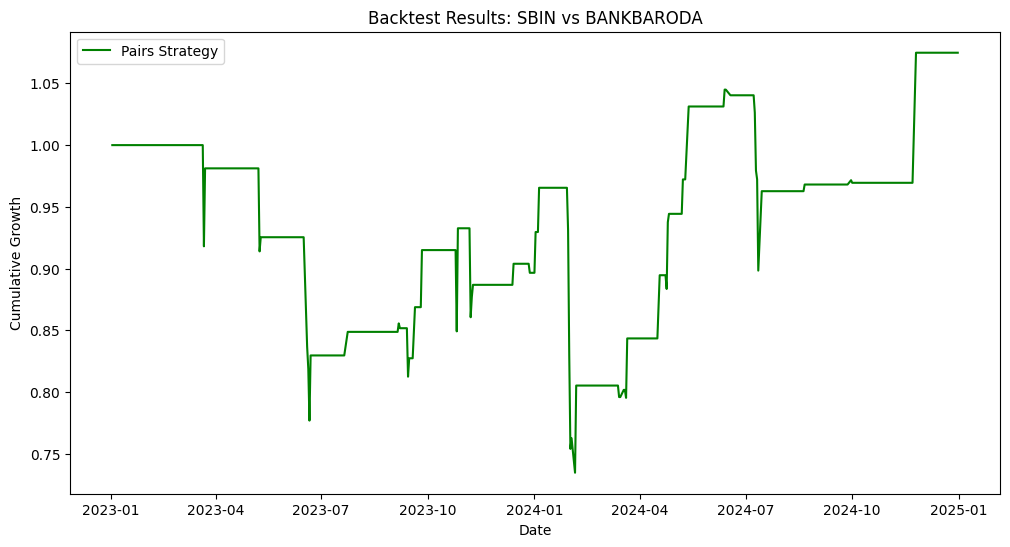

Final Return: 7.48%


In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Collecting Data
tickers = ['SBIN.NS', 'BANKBARODA.NS']
data = yf.download(tickers, start="2023-01-01", end="2025-01-01" , auto_adjust=True)

# Correlation Check 

prices = data['Close']
rolling_corr = prices['SBIN.NS'].rolling(60).corr(prices['BANKBARODA.NS'])

avg_corr = rolling_corr.mean()
print(f"Average Rolling Correlation (60-day): {avg_corr:.2f}")

# Calculate Hedge Ratio using OLS
Y = data['Close']['SBIN.NS']
X = data['Close']['BANKBARODA.NS']

X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
hedge_ratio = model.params['BANKBARODA.NS']

# Generate Spread and Z-Score

data['spread'] = (
    data['Close']['SBIN.NS']
    - hedge_ratio * data['Close']['BANKBARODA.NS']
)

data['zscore'] = (
    (data['spread'] - data['spread'].rolling(window=20).mean())
    / data['spread'].rolling(window=20).std()
)

# Cointegration Check (ADF Test on Spread)
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['spread'].dropna())

print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")


# Trading Signals
data['position'] = 0
data.loc[data['zscore'] > 2, 'position'] = -1  # Short the spread
data.loc[data['zscore'] < -2, 'position'] = 1   # Long the spread
data['position'] = data['position'].ffill().fillna(0) # Carry position until exit logic

# 5. Calculate Returns
# Strategy return = position * (return of SBIN − hedge_ratio * return of BANKBARODA)

data['returns'] = (
    data['position'].shift(1)
    * (
        data['Close']['SBIN.NS'].pct_change()
        - hedge_ratio * data['Close']['BANKBARODA.NS'].pct_change()
    )
)

data['cumulative_returns'] = (1 + data['returns'].fillna(0)).cumprod()


# Plot Results
plt.figure(figsize=(12, 6))
plt.plot(data['cumulative_returns'], label='Pairs Strategy', color='green')
plt.title('Backtest Results: SBIN vs BANKBARODA')
plt.xlabel('Date')
plt.ylabel('Cumulative Growth')
plt.legend()
plt.show()

print(f"Final Return: {(data['cumulative_returns'].iloc[-1] - 1) * 100:.2f}%")